In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn.functional as F
import timm
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from src.adversarial import fgsm
from src.utils import load_image, get_standard_transforms
from config import settings, load_in1k_labels

/home/andrew/.cache/pypoetry/virtualenvs/image-adversarial-noise-so7WhiLG-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Let's look only at resnet models trained on imagenet1k for now...

In [3]:
classes = load_in1k_labels()
timm.list_models(["resnet*" "*in1k"], pretrained=True)[:20]

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_in1k',
 'resnet26d.bt_in1k',
 'resnet26t.ra2_in1k',
 'resnet32ts.ra2_in1k',
 'resnet33ts.ra2_in1k',
 'resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k']

Load a relevant model

In [4]:
model = timm.create_model("resnet50.a1_in1k", pretrained=True)
model.to(settings.device)
model.eval()
assert model.num_classes == 1000

Load and transform example image

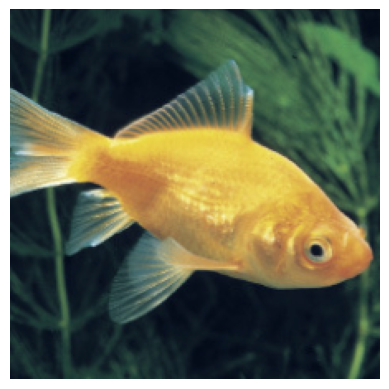

In [5]:
def tensor_imshow(img):
    
    np_img = np.transpose(img.squeeze().detach().numpy(), (1, 2, 0))
    
    # Scaling to avoid clipping
    np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())

    plt.imshow(np_img)
    plt.gca().set_axis_off()

image_paths = sorted(settings.images_path.glob("*.JPEG"))
transforms = get_standard_transforms()
original_image = load_image(image_paths[0])

# Transform and add batch dimension
original_image = transforms(original_image).unsqueeze(0)

tensor_imshow(original_image)

Run original through model and check prediction

In [6]:
output = model(original_image)

prob, class_idx = torch.max(F.softmax(output, dim=1), 1)
print(f"Original prediction: '{classes[class_idx.item()]}' (probability: {prob.item():.2f})")

Original prediction: 'goldfish, Carassius auratus' (probability: 1.00)


Choose a class to target

In [194]:
target_class = random.randint(a=0, b=1000)
print(f"Targetting class: '{classes[target_class]}'")

Targetting class: 'tusker'


Run FQSM attack for different values of epsilon

In [195]:
epsilon_range = np.arange(0.05, 0.95, 0.05)

perturbed_images = []
for epsilon in epsilon_range:
    perturbed_image = fgsm(model, original_image, target_class=target_class, epsilon=epsilon)
    perturbed_prob, class_idx = torch.max(F.softmax(model(perturbed_image), dim=1), 1)

    print(f"[Epsilon: {epsilon:.2f}] Perturbed prediction: '{classes[class_idx.item()]}' (probability: {perturbed_prob.item():.2f})")
    perturbed_images.append(perturbed_image.detach())

[Epsilon: 0.05] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.10] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.15] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.20] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.25] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.30] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.35] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.40] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 1.00)
[Epsilon: 0.45] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 0.96)
[Epsilon: 0.50] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 0.82)
[Epsilon: 0.55] Perturbed prediction: 'goldfish, Carassius auratus' (probability: 0.49)
[Epsilon: 0.60] Perturbed predic

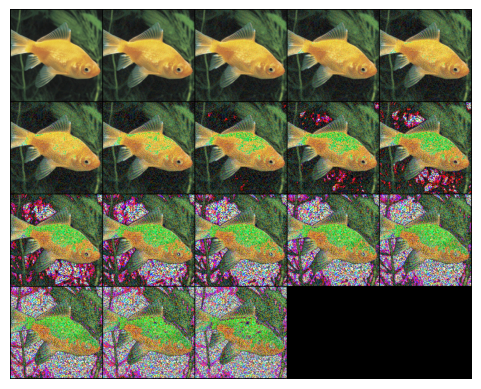

In [196]:
batch_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1).to(settings.device)
batch_std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1).to(settings.device)

unnorm_perturbed_images = torch.cat(perturbed_images) * batch_std + batch_mean
grid = make_grid(unnorm_perturbed_images, nrow=5)
plt.imshow(to_pil_image(grid))
plt.gca().set_axis_off()

Images are being perturbed and epsilon contraint is working, but still getting some strage results. Maybe too difficult to do in one step for 1000 classes? 

Let's try an iterative method...

In [197]:
from src.adversarial import pgd_attack

alpha = 0.01
max_steps = 20

perturbed_images = []
for epsilon in epsilon_range:
    perturbed_image, class_idx, prob, _ = pgd_attack(model, original_image, target_class, epsilon, alpha, max_steps)
    print(f"[Epsilon: {epsilon:.2f}] Perturbed prediction: '{classes[class_idx]}' (probability: {prob:.2f})")
    perturbed_images.append(perturbed_image.detach())

Running PGD attack ...


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:02<00:02,  3.79it/s, loss=1.73]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'tusker' (probability: 0.18)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.67it/s, loss=2.18]


Attack successful!
[Epsilon: 0.10] Perturbed prediction: 'tusker' (probability: 0.11)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.77it/s, loss=0.942]


Attack successful!
[Epsilon: 0.15] Perturbed prediction: 'tusker' (probability: 0.39)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.98it/s, loss=0.436]


Attack successful!
[Epsilon: 0.20] Perturbed prediction: 'tusker' (probability: 0.65)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:03<00:02,  3.51it/s, loss=1.57]


Attack successful!
[Epsilon: 0.25] Perturbed prediction: 'tusker' (probability: 0.21)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.81it/s, loss=0.372]


Attack successful!
[Epsilon: 0.30] Perturbed prediction: 'tusker' (probability: 0.69)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.80it/s, loss=1.26]


Attack successful!
[Epsilon: 0.35] Perturbed prediction: 'tusker' (probability: 0.28)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.71it/s, loss=0.818]


Attack successful!
[Epsilon: 0.40] Perturbed prediction: 'tusker' (probability: 0.44)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.67it/s, loss=1.64]


Attack successful!
[Epsilon: 0.45] Perturbed prediction: 'tusker' (probability: 0.19)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.72it/s, loss=1.51]


Attack successful!
[Epsilon: 0.50] Perturbed prediction: 'tusker' (probability: 0.22)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.86it/s, loss=1.89]


Attack successful!
[Epsilon: 0.55] Perturbed prediction: 'tusker' (probability: 0.15)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:03,  3.63it/s, loss=0.427]


Attack successful!
[Epsilon: 0.60] Perturbed prediction: 'tusker' (probability: 0.65)
Running PGD attack ...


 50%|█████     | 10/20 [00:02<00:02,  3.53it/s, loss=1.47]


Attack successful!
[Epsilon: 0.65] Perturbed prediction: 'tusker' (probability: 0.23)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.75it/s, loss=1.02]


Attack successful!
[Epsilon: 0.70] Perturbed prediction: 'tusker' (probability: 0.36)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.68it/s, loss=1.98]


Attack successful!
[Epsilon: 0.75] Perturbed prediction: 'tusker' (probability: 0.14)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.68it/s, loss=0.92]


Attack successful!
[Epsilon: 0.80] Perturbed prediction: 'tusker' (probability: 0.40)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.69it/s, loss=1.06]


Attack successful!
[Epsilon: 0.85] Perturbed prediction: 'tusker' (probability: 0.35)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.74it/s, loss=2.21]

Attack successful!
[Epsilon: 0.90] Perturbed prediction: 'tusker' (probability: 0.11)


This makes sense, the more we allow the image to be altered the less steps required for the attack to work (although the difference is minor). 

Let's double check the images for increasing epsilon.

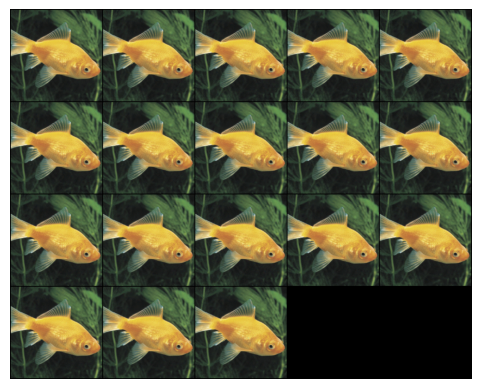

In [198]:
unnorm_perturbed_images = torch.cat(perturbed_images) * batch_std + batch_mean
grid = make_grid(unnorm_perturbed_images, nrow=5)
plt.imshow(to_pil_image(grid))
plt.gca().set_axis_off()

Is there actually a difference between them? Double check we are doing the right thing...

In [199]:
torch.linalg.matrix_norm(perturbed_images[-1] - perturbed_images[0])

tensor([[7.6435, 7.6579, 7.7000]])

Looks good! Now let's try for hitting a probability threshold of the target class...

Running PGD attack ...


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:03<00:01,  3.89it/s, loss=0.621]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'tusker' (probability: 0.54)
Running PGD attack ...


 60%|██████    | 12/20 [00:03<00:02,  3.79it/s, loss=0.474]


Attack successful!
[Epsilon: 0.10] Perturbed prediction: 'tusker' (probability: 0.62)
Running PGD attack ...


 60%|██████    | 12/20 [00:03<00:02,  3.85it/s, loss=0.224]


Attack successful!
[Epsilon: 0.15] Perturbed prediction: 'tusker' (probability: 0.80)
Running PGD attack ...


 60%|██████    | 12/20 [00:03<00:02,  3.68it/s, loss=0.303]


Attack successful!
[Epsilon: 0.20] Perturbed prediction: 'tusker' (probability: 0.74)
Running PGD attack ...


 65%|██████▌   | 13/20 [00:03<00:01,  3.87it/s, loss=0.239]


Attack successful!
[Epsilon: 0.25] Perturbed prediction: 'tusker' (probability: 0.79)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.74it/s, loss=0.679]


Attack successful!
[Epsilon: 0.30] Perturbed prediction: 'tusker' (probability: 0.51)
Running PGD attack ...


 75%|███████▌  | 15/20 [00:03<00:01,  3.89it/s, loss=0.206]


Attack successful!
[Epsilon: 0.35] Perturbed prediction: 'tusker' (probability: 0.81)
Running PGD attack ...


 50%|█████     | 10/20 [00:02<00:02,  3.69it/s, loss=0.202]


Attack successful!
[Epsilon: 0.40] Perturbed prediction: 'tusker' (probability: 0.82)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.91it/s, loss=0.509]


Attack successful!
[Epsilon: 0.45] Perturbed prediction: 'tusker' (probability: 0.60)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.81it/s, loss=0.505]


Attack successful!
[Epsilon: 0.50] Perturbed prediction: 'tusker' (probability: 0.60)
Running PGD attack ...


 65%|██████▌   | 13/20 [00:03<00:01,  3.99it/s, loss=0.605]


Attack successful!
[Epsilon: 0.55] Perturbed prediction: 'tusker' (probability: 0.55)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:03,  3.61it/s, loss=0.273]


Attack successful!
[Epsilon: 0.60] Perturbed prediction: 'tusker' (probability: 0.76)
Running PGD attack ...


 60%|██████    | 12/20 [00:03<00:02,  3.90it/s, loss=0.331]


Attack successful!
[Epsilon: 0.65] Perturbed prediction: 'tusker' (probability: 0.72)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.70it/s, loss=0.381]


Attack successful!
[Epsilon: 0.70] Perturbed prediction: 'tusker' (probability: 0.68)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:03,  3.66it/s, loss=0.32]


Attack successful!
[Epsilon: 0.75] Perturbed prediction: 'tusker' (probability: 0.73)
Running PGD attack ...


 65%|██████▌   | 13/20 [00:03<00:01,  3.76it/s, loss=0.385]


Attack successful!
[Epsilon: 0.80] Perturbed prediction: 'tusker' (probability: 0.68)
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:02,  3.67it/s, loss=0.45]


Attack successful!
[Epsilon: 0.85] Perturbed prediction: 'tusker' (probability: 0.64)
Running PGD attack ...


 55%|█████▌    | 11/20 [00:02<00:02,  3.83it/s, loss=0.571]


Attack successful!
[Epsilon: 0.90] Perturbed prediction: 'tusker' (probability: 0.56)


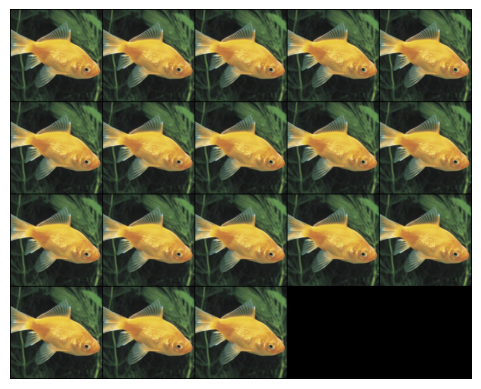

In [200]:
prob_threshold = 0.5

perturbed_images = []
for epsilon in epsilon_range:
    perturbed_image, class_idx, prob, _ = pgd_attack(model, original_image, target_class, epsilon, alpha, max_steps, prob_threshold)
    print(f"[Epsilon: {epsilon:.2f}] Perturbed prediction: '{classes[class_idx]}' (probability: {prob:.2f})")
    perturbed_images.append(perturbed_image.detach())

unnorm_perturbed_images = torch.cat(perturbed_images) * batch_std + batch_mean
grid = make_grid(unnorm_perturbed_images, nrow=5)
plt.imshow(to_pil_image(grid))
plt.gca().set_axis_off()

Let's do some more examples with a fixed epsilon and randomized targets


Input image: n01443537_goldfish
Targetting class: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM'
Running PGD attack ...


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:03<00:02,  3.89it/s, loss=0.599]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM' (probability: 0.55)

Input image: n01491361_tiger_shark
Targetting class: 'parachute, chute'
Running PGD attack ...


 20%|██        | 4/20 [00:01<00:04,  3.31it/s, loss=0.217]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'parachute, chute' (probability: 0.81)

Input image: n01614925_bald_eagle
Targetting class: 'hoopskirt, crinoline'
Running PGD attack ...


 40%|████      | 8/20 [00:02<00:03,  3.71it/s, loss=0.00737]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'hoopskirt, crinoline' (probability: 0.99)

Input image: n01755581_diamondback
Targetting class: 'prayer rug, prayer mat'
Running PGD attack ...


 30%|███       | 6/20 [00:01<00:04,  3.26it/s, loss=0.331]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'prayer rug, prayer mat' (probability: 0.72)

Input image: n03393912_freight_car
Targetting class: 'feather boa, boa'
Running PGD attack ...


 40%|████      | 8/20 [00:02<00:03,  3.61it/s, loss=0.147]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'feather boa, boa' (probability: 0.86)

Input image: n03670208_limousine
Targetting class: 'ram, tup'
Running PGD attack ...


 45%|████▌     | 9/20 [00:02<00:03,  3.57it/s, loss=0.0875]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'ram, tup' (probability: 0.92)

Input image: n03710193_mailbox
Targetting class: 'white stork, Ciconia ciconia'
Running PGD attack ...


 80%|████████  | 16/20 [00:04<00:01,  3.82it/s, loss=0.61] 


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'white stork, Ciconia ciconia' (probability: 0.54)

Input image: n03773504_missile
Targetting class: 'dishwasher, dish washer, dishwashing machine'
Running PGD attack ...


 35%|███▌      | 7/20 [00:01<00:03,  3.70it/s, loss=0.153]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'dishwasher, dish washer, dishwashing machine' (probability: 0.86)

Input image: n03877845_palace
Targetting class: 'admiral'
Running PGD attack ...


 65%|██████▌   | 13/20 [00:03<00:01,  3.88it/s, loss=0.453]


Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'admiral' (probability: 0.64)

Input image: n04099969_rocking_chair
Targetting class: 'Dandie Dinmont, Dandie Dinmont terrier'
Running PGD attack ...


 35%|███▌      | 7/20 [00:01<00:03,  3.56it/s, loss=0.672]

Attack successful!
[Epsilon: 0.05] Perturbed prediction: 'Dandie Dinmont, Dandie Dinmont terrier' (probability: 0.51)

Total successful classes: 10/10
Total above threshold (probability > 0.5): 10/10


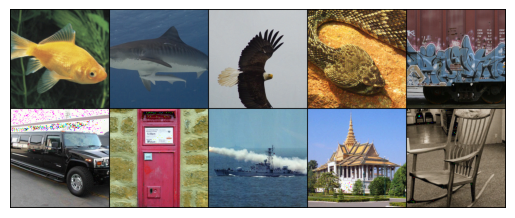

In [201]:
epsilon = 0.05

perturbed_images = []
target_correct = 0
desired_probability = 0
for path in image_paths:

    input_image = load_image(path)
    input_image = transforms(input_image).unsqueeze(0)
    y = random.randint(a=0, b=1000)
    print(f"\nInput image: {path.stem}", f"Targetting class: '{classes[y]}'", sep="\n")

    perturbed_image, class_idx, prob, success = pgd_attack(model, input_image, y, epsilon, alpha, max_steps, prob_threshold)
    print(f"[Epsilon: {epsilon:.2f}] Perturbed prediction: '{classes[class_idx]}' (probability: {prob:.2f})")
    perturbed_images.append(perturbed_image.detach())

    if success:
        target_correct += 1

        if prob > prob_threshold:
            desired_probability += 1


print(
    f"\nTotal successful classes: {target_correct}/{len(image_paths)}",
    f"Total above threshold (probability > {prob_threshold}): {desired_probability}/{len(image_paths)}",
    sep="\n"
    )

unnorm_perturbed_images = torch.cat(perturbed_images) * batch_std + batch_mean
grid = make_grid(unnorm_perturbed_images, nrow=5)
plt.imshow(to_pil_image(grid))
plt.gca().set_axis_off()